C:\Users\D Pradeep\AppData\Local\Temp\ipykernel_17284\3890708373.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X[i] = (vector[i] - temp_sum) / matrix[i, i]



Errors:
Gram-Schmidt Error: 2.99656e-07
Householder QR Error: 2.98817e-07
SVD Error: 2.98817e-07
Normal Equation Error: 4.02710e-02


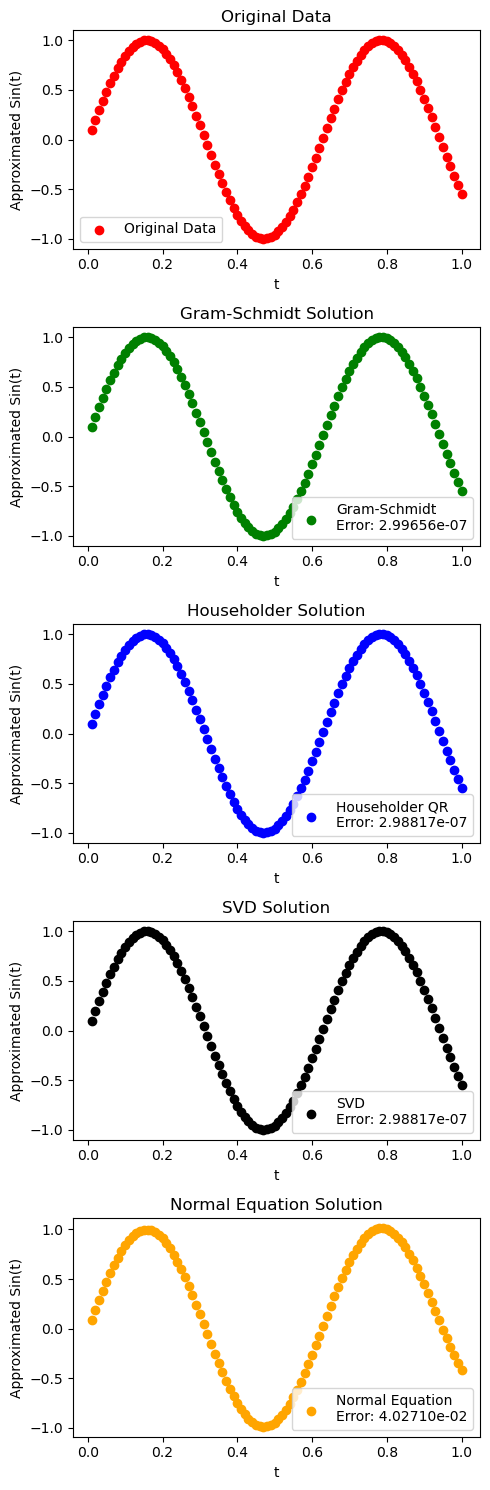

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy

# Define the data points
t = np.linspace(0.01, 1, 100)
b = np.sin(10 * t)
m = 15
A = np.zeros((len(t), m))

# Create the Vandermonde matrix
for count, i in enumerate(t):
    A[count, :] = [i**j for j in range(m)]

# Define modified QR decomposition
def modified_QR(matrix):
    rows, cols = matrix.shape
    Q = np.zeros((rows, cols))
    R = np.zeros((cols, cols))
    V = matrix.copy()

    for i in range(cols):
        R[i, i] = np.linalg.norm(V[:, i])
        Q[:, i] = V[:, i] / R[i, i]
        for j in range(i + 1, cols):
            R[i, j] = np.dot(Q[:, i], V[:, j])
            V[:, j] -= R[i, j] * Q[:, i]
    
    return Q, R

# Define backsubstitution for solving linear systems
def backsubstitution(matrix, vector):
    rows, cols = matrix.shape
    X = np.zeros(cols)
    for i in range(cols - 1, -1, -1):
        temp_sum = np.dot(matrix[i, i + 1:], X[i + 1:])
        X[i] = (vector[i] - temp_sum) / matrix[i, i]
    return X

# Gram-Schmidt QR decomposition
bi=copy.deepcopy(b)
bi = bi.reshape((-1, 1))
gram_Q, gram_R = modified_QR(A)
gram_Q_t_b = gram_Q.T @ bi
gram_X = backsubstitution(gram_R, gram_Q_t_b)
gram_sin = A @ gram_X

# Householder QR decomposition
def sign(x):
    return 1 if x >= 0 else -1

def householder_R(matrix):
    matrix = copy.deepcopy(matrix)
    rows, cols = matrix.shape
    v = [None] * cols
    for k in range(cols):
        x = matrix[k:, k].reshape(-1, 1)
        unit_vector = np.array([1] + [0] * (x.shape[0] - 1)).reshape(-1, 1)
        v[k] = sign(x[0, 0]) * np.linalg.norm(x) * unit_vector + x
        v[k] /= np.linalg.norm(v[k])
        matrix[k:, k:] -= 2 * v[k] @ (v[k].T @ matrix[k:, k:])
    return matrix, v

house_R, house_v = householder_R(A)

# Householder QR backsubstitution
def householder_Qb(house_v, bi):
    cols = len(house_v)
    rows = bi.shape[0]
    for k in range(cols):
        bi[k:] -= 2 * house_v[k] @ (house_v[k].T @ bi[k:])
    return bi

bi = copy.deepcopy(b)
house_Q_t_b = householder_Qb(house_v, bi)
house_X = backsubstitution(house_R, house_Q_t_b)
house_sin = A @ house_X

# SVD-based method
def SVD_solution(matrix, b):
    U, sigma, V_t = np.linalg.svd(matrix, full_matrices=False)
    sigma_inv = np.diag(1 / sigma)
    U_t_b = U.T @ b
    SVD_w = sigma_inv @ U_t_b
    svd_x = V_t.T @ SVD_w
    return svd_x

svd_X = SVD_solution(A, b)
SVD_sin = A @ svd_X

# Normal equation method
def normal_equation(matrix, b):
    A_t_b = np.matmul(matrix.T, b)
    A_t_A = np.matmul(matrix.T, matrix)
    x = np.matmul(np.linalg.inv(A_t_A), A_t_b)
    return x

normal_X = normal_equation(A, b)
normal_sin = A @ normal_X

# Calculate 2-norm errors with high precision
gram_error = np.linalg.norm(b - gram_sin, ord=2)/np.linalg.norm(b, ord=2)
house_error = np.linalg.norm(b - house_sin, ord=2)/np.linalg.norm(b, ord=2)
svd_error = np.linalg.norm(b - SVD_sin, ord=2)/np.linalg.norm(b, ord=2)
normal_error = np.linalg.norm(b - normal_sin, ord=2)/np.linalg.norm(b, ord=2)

# Print errors in scientific notation with more precision
print()
print('Errors:')
print(f'Gram-Schmidt Error: {gram_error:.5e}')
print(f'Householder QR Error: {house_error:.5e}')   
print(f'SVD Error: {svd_error:.5e}')    
print(f'Normal Equation Error: {normal_error:.5e}')

# Plot Original Data
fig, axs = plt.subplots(5, 1, figsize=(5, 15))

# Plot Original Data
axs[0].scatter(t, b, color='red', label='Original Data')
axs[0].set_title('Original Data')
axs[0].legend()

# Plot Gram-Schmidt solution and error
axs[1].scatter(t, gram_sin, color='green', label=f'Gram-Schmidt\nError: {gram_error:.5e}')
axs[1].set_title('Gram-Schmidt Solution')
axs[1].legend()

# Plot Householder solution and error
axs[2].scatter(t, house_sin, color='blue', label=f'Householder QR\nError: {house_error:.5e}')
axs[2].set_title('Householder Solution')
axs[2].legend()

# Plot SVD solution and error
axs[3].scatter(t, SVD_sin, color='black', label=f'SVD\nError: {svd_error:.5e}')
axs[3].set_title('SVD Solution')
axs[3].legend()

# Plot Normal Equation solution and error
axs[4].scatter(t, normal_sin, color='orange', label=f'Normal Equation\nError: {normal_error:.5e}')
axs[4].set_title('Normal Equation Solution')
axs[4].legend()

# Add axis labels
for ax in axs.flat:
    ax.set(xlabel='t', ylabel='Approximated Sin(t)')

plt.tight_layout()
plt.show()


In [4]:
def condition_number(matrix):
    U, s, Vt = np.linalg.svd(matrix, full_matrices=False)
    return np.max(s) / np.min(s)

# Compute the condition number of the Vandermonde matrix A
cond_number_A = condition_number(A)
print(A.shape)
print(f'Condition Number of Matrix A: {cond_number_A:.20f}')

(100, 15)
Condition Number of Matrix A: 27697041196.29529190063476562500
